# Biases and CCDPROC
J. C. Runnoe, 2021

This Jupyter notebook includes tasks and code snippets to help you interact with subtracting the bias. It also provides an introduction to the CCDPROC Python package, which has many tools for reducing CCD data. The cells below are not exhaustive, so expect to add cells, modify code, and add new code to complete the tasks. 

For additional help on CCDPROC, CCDData, and ImageCollections, see this notebook: <br>
<a href="https://github.com/mwcraig/ccd-reduction-and-photometry-guide/blob/80368509444a05b9bb783059c456a86bc5776735/notebooks/01-11-reading-images.ipynb">01-11 reading-images</a> <br>

For additional help on bias characterization and subtraction, see these notebooks: <br>
<a href="https://github.com/mwcraig/ccd-reduction-and-photometry-guide/blob/master/notebooks/01-08-Overscan.ipynb">01-08 Overscan</a> <br>
<a href="https://github.com/mwcraig/ccd-reduction-and-photometry-guide/blob/master/notebooks/02-00-Handling-overscan-trimming-and-bias-subtraction.ipynb">02-00 Handling-overscan-trimming-and-bias-subtraction</a> <br>
<a href="https://github.com/mwcraig/ccd-reduction-and-photometry-guide/blob/master/notebooks/02-01-Calibrating-bias-images.ipynb">02-01 Calibrating-bias-images</a> <br>
<a href="https://github.com/mwcraig/ccd-reduction-and-photometry-guide/blob/master/notebooks/02-04-Combine-bias-images-to-make-master.ipynb">02-04 Combine-bias-images-to-make-master</a> <br>

In [2]:
# import block
import numpy as np
from astropy.io import fits
%matplotlib inline
from matplotlib import pyplot as plt
from astropy.visualization import hist
import ccdproc as ccdp
from matplotlib import rc

# for fitting models
from astropy.modeling import fitting
from astropy.modeling.models import Polynomial1D,Chebyshev1D,Legendre1D

#from ccdproc import ImageFileCollection
#from astropy.modeling import fitting
#from astropy.stats import mad_std
#from astropy.nddata import CCDData
#from scipy import stats
#from astropy import units as u

In [3]:
# plotting defaults
# Use custom style for larger fonts and figures
phot_tutorial_dir = '/home/kyle/Homework/Astro8060/ccd-reduction-and-photometry-guide/notebooks'
plt.style.use(phot_tutorial_dir+'/guide.mplstyle')

# Set some default parameters for the plots below
rc('font', size=12)
rc('axes', grid=True)

In [4]:
# define directories
data_dir = '/home/kyle/Homework/Astro8060/NoBackupImages/raw/'
reduced_dir = '/home/kyle/Homework/Astro8060/NoBackupImages/reduced/'

## 1. Data wrangling

<b>The log file</b><br>
The observing log is stored in your Imaging/ data directory in a file called log.txt. This file has all the information you will need about the data and how they were taken. It has columns for:
 - exposure number (which is also the file name)
 - exposure type
 - exposure time [s]
 - filter
 - universal time (UT) [h:mm]
 - other notes <br>

The formatting for the log file is not completely consistent. For example, in junk exposures used to focus the telescope the notes column which contains information about the focus value may appear a column or two early because no UT was recorded.

In the notes column, you will also often see something that says "X=1.18". Here, X is meant to represent $\chi$, the airmass.

<b> Adding information to the FITS headers </b>

Importantly, a lot of the information in the log file <i>is not</i> packaged in the fits file headers. If you use existing Python packages to reduce your data, it may be necessary to add some header keywords. Here is an example of <a href="https://docs.astropy.org/en/stable/io/fits/usage/headers.html">how to add keywords to fits headers</a>. 

Try adding keywords to the header to include the image type for your bias frames.

<font color='red'>Remember, if you haven't already, copy your Imaging/ directory to a reduced/ directory before you start so that you don't overwrite your raw files.</font>

In [5]:
# make an array of your bias filenames
# you can do this efficiently as a loop if they are all taken in a row
# you will need to update the numbers below to correctly list bias files
nfiles = 111-93+1 # number of files in a sequence
nlow   = 93  # the exposure number for the first file 

bias_files = [reduced_dir+'a'+str(i).zfill(3)+'.fits' for i in np.arange(nfiles)+nlow]
print([i for i in np.arange(nfiles)+nlow])

# you can use list comprehension when you need to do something many times
# one example is to use it to open all the bias files and headers
hdus = [fits.open(file) for file in bias_files]
hdrs = [hdu[0].header for hdu in hdus]
biases = [hdu[0].data for hdu in hdus]

[93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111]


In [6]:
# inspect the hdrs and biases
# can you print the EXPTIME keyword for the second bias frame?ty
hdrs[0]

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                   16 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 2200 / Axis length                                    
NAXIS2  =                 2048 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2009-09-15T15:56:40' / Date FITS file was generated                  
IRAF-TLM= '09:56:39 (15/09/2009)' / Time of last modification                   
DATAMIN =           5.720000E2 / Minimum data value                             
DATAMAX =           7.536000E3 / Maximum data value                             
OBJECT  = 'SERVICE '           / Name of the object observed                    
DATE-OBS= '2009-06-23T04:19:

<b> Setting a keyword </b><br>
The syntax to set a header keyword in Python is:

hdr['keyword'] = 'value'

Some useful header keywords include:
 - IMAGETYP - the type of image (e.g., bias, science, dark, skyflat)
 - FILTER - the filter (e.g., V, Halpha, none)
 - BIASSEC - the overscan region of the frame
 - TRIMSEC - the "good" part of the frame (i.e. everything but overscan)
 
The BIASSEC and TRIMSEC keyword values can take the string value '[col_lo:col_hi,row_lo:row_hi]', where you fill in numbers for the column and row ranges that identify the region. Note that the FITS standard and Python do indexing differently. In Python, it's [row,col] and count from 0. In FITS, indexing is [col,row] and starts counting at 1.

Once you update these, you may want to write them back out to a fits file. Here is an example of <a href="https://docs.astropy.org/en/stable/io/fits/">how to write fits files</a>.

<b> A note on file conventions </b><br>
Your task when reducing data is to invert the equation for observed brightness and recover the true brightness in each pixel of your image. In practice, each step may produce files that have had one relevant correction applied to them. When you save a file, it is standard to add a letter to the filename to indicate which corrections have been applied. These are:
 - o  -  Overscan subtraction
 - t  -  Trimming
 - z  -  Zero level/bias subtraction
 - d  -  Dark count subtraction
 - f  -  Flat field calibration
 - i  -  Illumination correction
 - q  -  Fringe correction
 
You may not always need to apply all corrections, so you may not always use all of these. It is also acceptable to choose different flags, so long as they are clear.

In this case, you have not yet applied any corrections so you can just overwrite the existing file (since it's copied in your reduced/ directory) with the new header keywords.

In [7]:
imgSize = biases[0].shape
print(imgSize)

for i in range(np.size(hdus)):
    print("Working on file#: {}".format(i)) # place holder for loop
    hdrs[i]['IMAGETYP']=('bias','Type of image')
    hdrs[i]['FILTER']=('None','Filter used')
    hdrs[i]['BIASSEC']=('[1:2048, 2102:2200]','bais sample area')
    hdrs[i]['TRIMSEC']=('[1:2048, 54:2101]','Usable data')
    
    # add header keywords for BIASSEC, TRIMSEC, FILTER, and IMAGETYP
    
    hdus[i].writeto(bias_files[i],overwrite=True)
    # write the fits file out with the new header keywords
    # note that you have to write out the whole HDU - i.e. the data+header package  

del hdus # hdus take a lot of memory, don't leave them open when you don't need to
del hdrs

(2048, 2200)
Working on file#: 0
Working on file#: 1
Working on file#: 2
Working on file#: 3
Working on file#: 4
Working on file#: 5
Working on file#: 6
Working on file#: 7
Working on file#: 8
Working on file#: 9
Working on file#: 10
Working on file#: 11
Working on file#: 12
Working on file#: 13
Working on file#: 14
Working on file#: 15
Working on file#: 16
Working on file#: 17
Working on file#: 18


In [8]:
fits.open(bias_files[0])[0].header
# read in one of your fits files
# print its header and check that the new keywords are there

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                   16 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 2200 / Axis length                                    
NAXIS2  =                 2048 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2009-09-15T15:56:40' / Date FITS file was generated                  
IRAF-TLM= '09:56:39 (15/09/2009)' / Time of last modification                   
DATAMIN =           5.720000E2 / Minimum data value                             
DATAMAX =           7.536000E3 / Maximum data value                             
OBJECT  = 'SERVICE '           / Name of the object observed                    
DATE-OBS= '2009-06-23T04:19:

# 2. Fitting the overscan region

The bias in each frame may have two components, the absolute level which can vary with time and other parameters, plus any two-dimensional pattern (i.e., the bias may not be the same in every pixel). Here, we will explore the overscan region which is a good measure of the bias level at different times, telescope positions, and so on (make sure you know why this is).

The Python package below has tools for handling this overscan subtraction, but first let's do some exploration to determine what parameters to feed it.

The overscan region in each frame will extend over some number of columns and rows. In our case, the overscan region is a vertical strip on the right of the frame. One way to characterize it would be to use its average value, or median value and subtract this from the rest of the image. But if the pixels near the top of the frame have systematically different values than ones near the bottom, we would not be accounting for that with a single value. It might be better to subtract more for pixels near the top than pixels near the bottom. Essentially, we can characterize how the bias level varies along a column (although not a row, because a row extends into the data section of the chip).

<b>Plot the mean and median pixel values as a function of row in the overscan region.</b>

In [9]:
# read in the a093 bias frame
print(bias_files[0])
bias_frame = fits.open(bias_files[0])
bias = bias_frame[0].data #np.ones(np.shape(biases[0])[0:]) # this placeholder is an array of ones shaped like your images

/home/kyle/Homework/Astro8060/NoBackupImages/reduced/a093.fits


In [10]:
# select the overscan region
# you may want to use DS9 on a flat frame to find the relevant rows/cols
# it should be the same for all frames taken in this data set

# use these variables to specify the 
# row and col range for the overscan 
# you can rename them to row and col 
# if you figure out which is which
biasSec = bias_frame[0].header['BIASSEC']
print(biasSec)
#Could get the EXACT values of BIASSEC using code. Too Lazy

lo1 = 1
hi1 = 2048
lo2 = 2102+20 #Add extra to get away from data (accidental exposer)
hi2 = 2200

# find the mean and median bias values in the overscan region
# do this by collapsing the columns in the overscan
bias_mn = np.mean(bias[lo1:hi1,lo2:hi2],axis=1)
bias_md = np.median(bias[lo1:hi1,lo2:hi2],axis=1)

# determine whether to use average or median to collapse columns
print('The mean has smaller rms ({0:4.2f}) than the median ({1:4.2f}).'.format(np.std(bias_mn),np.std(bias_md)))

[1:2048, 2102:2200]
The mean has smaller rms (0.45) than the median (0.52).


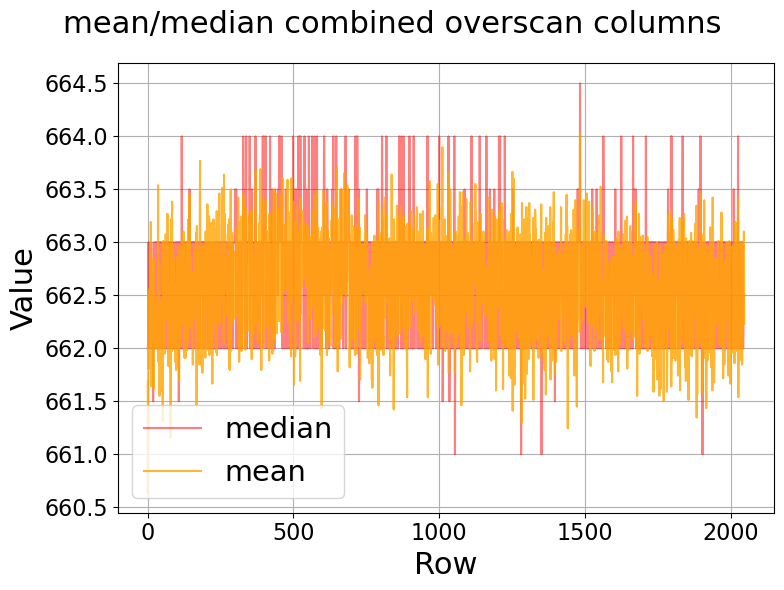

In [11]:
# plot the mean and median bias value in the overscan region

# make an array for the rows
rows_in_overscan = np.shape(bias_mn)[0] # how many rows are in the overscan region?
rows = np.arange(rows_in_overscan)

# make the plot
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(rows,bias_md,ls='-',c='r',label='median',alpha=0.5)
ax.plot(rows,bias_mn,ls='-',c='orange',label='mean',alpha=0.8)
ax.legend()
ax.set_xlabel(r'Row',fontsize=22)
ax.set_ylabel(r'Value',fontsize=22)
fig.suptitle('mean/median combined overscan columns', fontsize=22)
fig.tight_layout()
plt.show()

<b>Fit the overscan trend with a function</b><br>

We can use a polynomial function to characterize how the overscan region changes as a function of row. The astropy Python distribution has a handy class that includes many different mathematical <a href="https://docs.astropy.org/en/stable/modeling/">models</a> that you can use. Here is an example of <a href="https://learn.astropy.org/rst-tutorials/Models-Quick-Fit.html">fitting models to data</a>.

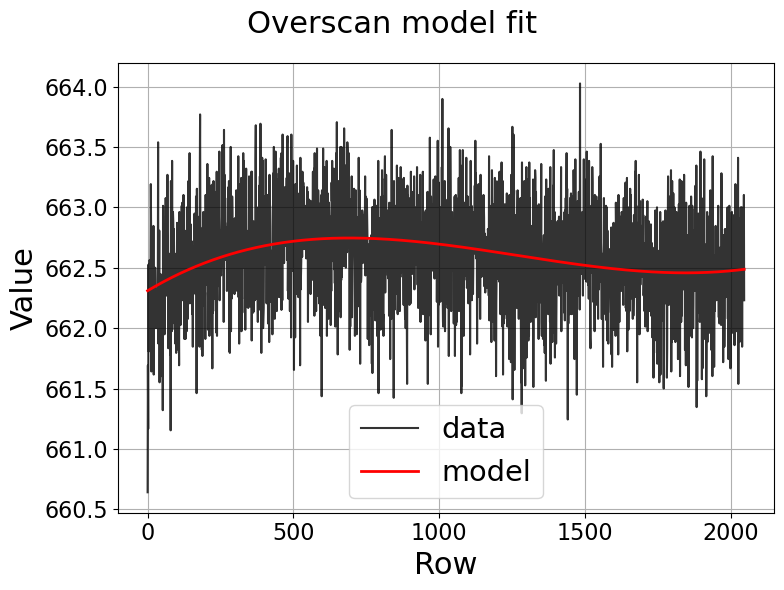

In [12]:
# define a minimization method
# some options are LinearLSQFitter(), SimplexLSQFitter(), LevMarLSQFitter()
# not all minimizers work on all problems, so experiment
fitter = fitting.LinearLSQFitter()

# choose a model
# these are from the import block
# options are Polynomial1D,Chebyshev1D,Legendre1D 
# they generally take the polynomial order as an input
# but see their inputs here: https://docs.astropy.org/en/stable/modeling/polynomial_models.html
degree = 3 # this will be a constant
model = Polynomial1D(degree)

# set up the inputs
xvals = rows
yvals = bias_mn
wgts  = np.ones_like(bias_mn) # weight all the same

# find the best fit
best_fit = fitter(model, xvals, yvals, weights=wgts)    

# plot it
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(xvals,yvals,ls='-',c='k',label='data',alpha=0.8)
ax.plot(xvals,best_fit(xvals),ls='-',lw=2,c='r',alpha=1,label='model')
ax.legend()
ax.set_xlabel(r'Row',fontsize=22)
ax.set_ylabel(r'Value',fontsize=22)
fig.suptitle('Overscan model fit', fontsize=22)
fig.tight_layout()
plt.show()

## 3. CCDPROC

In the old IRAF language, the package for reducing CCD data sets was called CCDPROC. It has been ported over to Python, and is still called by the same name. You can find its documentation here:

https://ccdproc.readthedocs.io/en/latest/

This package has many tools and defaults that make reducing data easier. That said, many of the tasks we will complete can easily be coded without CCDPROC. I will include information here for you to learn the CCDPROC package, but I will always accept your own code to reduce data in lieu of using these pre-written tools. 

<b>CCDData</b><br>
CCDPROC stores images in a class called <a href="https://docs.astropy.org/en/stable/api/astropy.nddata.CCDData.html#astropy.nddata.CCDData">CCDData</a>. A CCDData object stores the image, uncertainties, a unit for these quantities, a mask for identifying bad pixels, and a coordinate system (referred to as a WCS -- for world coordinate system).

<b>ImageCollection</b><br>
The CCDPROC class for groups of images is called an <a href="https://ccdproc.readthedocs.io/en/latest/api/ccdproc.ImageFileCollection.html">ImageCollection</a>. These are easily filtered by FITS header keyword, which is why we went to the trouble above of adding lots of keywords to the frame headers.

<b>Tasks for bias removal</b><br>
Three functions that are especially useful for bias characterization and subtraction are called <a href="https://ccdproc.readthedocs.io/en/latest/api/ccdproc.combine.html">CCDPROC.COMBINE</a>, <a href="https://ccdproc.readthedocs.io/en/latest/api/ccdproc.subtract_overscan.html">CCDPROC.SUBTRACT_OVERSCAN</a> and <a href="https://ccdproc.readthedocs.io/en/latest/api/ccdproc.trim_image.html">CCDPROC.TRIM_IMAGE</a>. There are many examples for syntax to use all of these methods in the notebooks <a href="https://github.com/mwcraig/ccd-reduction-and-photometry-guide/tree/master/notebooks
">here</a>.

Note that the CCDPROC tasks sometimes take image sections as inputs(e.g., to identify the overscan region). These can be given either in Python as a slice of an array, or as a header keyword. <font color='red'>Danger, the indexing works differently in these two cases!</font> In the first case, use Python indexing. In the second, use FITS.

Use CCDPROC.SUBTRACT_OVERSCAN and CCDPROC.TRIM_IMAGE with the best parameters from \#2 above to subtract and trim your bias image. Then open and display the same image in Python.

In [13]:
# open your images as an ImageCollection, 
# isolate the biases, and check that your 
# new header keywords are present

# note that the include/exclude options can be useful for grabbing only specific files
# for example, you could grab all your bias-subtracted images with glob_include='*otz.fits'
# but we haven't done anything yet, so open everything to start
imgs = ccdp.ImageFileCollection(reduced_dir,glob_include='*.fits',glob_exclude='master*') 

In [15]:
# explore the image collection, try uncommenting each of the following:
# (do them one at a time, you'll get a nicely formatted print without 
# including a print statement if it's the last thing in the cell)

#dir(imgs)     # this will print all the things associated with an image collection
#imgs.keywords # this is a list of available header keywords, good thing you added some!
imgs.summary   # summary table

file,simple,bitpix,naxis,naxis1,naxis2,extend,bscale,bzero,origin,date,iraf-tlm,datamin,datamax,object,date-obs,timesys,observat,sidetime,objepoch,airmass,exptime,ha,telescop,instrume,filter1,filter2,telra,teldec,observer,comment,imagetyp,filter,biassec,trimsec
str9,bool,int64,int64,int64,int64,bool,float64,float64,str37,str19,str21,float64,float64,str7,str23,str3,str11,str10,float64,float64,float64,str11,str9,str10,str4,str4,str11,str12,str8,str19,object,object,object,object
a001.fits,True,16,2,2200,2048,False,1.0,32768.0,NOAO-IRAF FITS Image Kernel July 2003,2009-09-15T15:55:16,09:55:15 (15/09/2009),0.0,65535.0,SERVICE,2009-06-23T01:43:32.000,UTC,Observatory,21:52:56.8,2000.0,4.101808827966386,3.0,0:1:20.24,Telescope,Instrument,None,None,21:51:36.56,-34:39:29.75,Observer,"None,None,None,None",--,--,--,--
a002.fits,True,16,2,2200,2048,False,1.0,32768.0,NOAO-IRAF FITS Image Kernel July 2003,2009-09-15T15:55:16,09:55:16 (15/09/2009),0.0,65535.0,SERVICE,2009-06-23T01:44:22.000,UTC,Observatory,21:52:56.8,2000.0,4.101808827966386,3.0,0:1:20.24,Telescope,Instrument,None,None,21:51:36.56,-34:39:29.75,Observer,"None,None,None,None",--,--,--,--
a003.fits,True,16,2,2200,2048,False,1.0,32768.0,NOAO-IRAF FITS Image Kernel July 2003,2009-09-15T15:55:17,09:55:16 (15/09/2009),0.0,65535.0,SERVICE,2009-06-23T01:44:52.000,UTC,Observatory,21:52:56.8,2000.0,4.101808827966386,1.0,0:1:20.24,Telescope,Instrument,None,None,21:51:36.56,-34:39:29.75,Observer,"None,None,None,None",--,--,--,--
a004.fits,True,16,2,2200,2048,False,1.0,32768.0,NOAO-IRAF FITS Image Kernel July 2003,2009-09-15T15:55:17,09:55:17 (15/09/2009),0.0,65535.0,SERVICE,2009-06-23T01:45:32.000,UTC,Observatory,21:52:56.8,2000.0,4.101808827966386,1.0,0:1:20.24,Telescope,Instrument,None,None,21:51:36.56,-34:39:29.75,Observer,"None,None,None,None",--,--,--,--
a005.fits,True,16,2,2200,2048,False,1.0,32768.0,NOAO-IRAF FITS Image Kernel July 2003,2009-09-15T15:55:18,09:55:17 (15/09/2009),0.0,50846.0,SERVICE,2009-06-23T01:47:01.000,UTC,Observatory,21:52:56.8,2000.0,4.101808827966386,1.0,0:1:20.24,Telescope,Instrument,None,None,21:51:36.56,-34:39:29.75,Observer,"None,None,None,None",--,--,--,--
a006.fits,True,16,2,2200,2048,False,1.0,32768.0,NOAO-IRAF FITS Image Kernel July 2003,2009-09-15T15:55:19,09:55:18 (15/09/2009),0.0,50217.0,SERVICE,2009-06-23T01:47:41.000,UTC,Observatory,21:52:56.8,2000.0,4.101808827966386,1.0,0:1:20.24,Telescope,Instrument,None,None,21:51:36.56,-34:39:29.75,Observer,"None,None,None,None",--,--,--,--
a007.fits,True,16,2,2200,2048,False,1.0,32768.0,NOAO-IRAF FITS Image Kernel July 2003,2009-09-15T15:55:19,09:55:19 (15/09/2009),0.0,49940.0,SERVICE,2009-06-23T01:48:27.000,UTC,Observatory,21:52:56.8,2000.0,4.101808827966386,1.0,0:1:20.24,Telescope,Instrument,None,None,21:51:36.56,-34:39:29.75,Observer,"None,None,None,None",--,--,--,--
a008.fits,True,16,2,2200,2048,False,1.0,32768.0,NOAO-IRAF FITS Image Kernel July 2003,2009-09-15T15:55:20,09:55:19 (15/09/2009),0.0,49115.0,SERVICE,2009-06-23T01:49:26.000,UTC,Observatory,21:52:56.8,2000.0,4.101808827966386,1.0,0:1:20.24,Telescope,Instrument,None,None,21:51:36.56,-34:39:29.75,Observer,"None,None,None,None",--,--,--,--
a009.fits,True,16,2,2200,2048,False,1.0,32768.0,NOAO-IRAF FITS Image Kernel July 2003,2009-09-15T15:55:20,09:55:20 (15/09/2009),0.0,48778.0,SERVICE,2009-06-23T01:49:59.000,UTC,Observatory,21:52:56.8,2000.0,4.101808827966386,1.0,0:1:20.24,Telescope,Instrument,None,None,21:51:36.56,-34:39:29.75,Observer,"None,None,None,None",--,--,--,--


In [14]:
# isolate the biases from all the other frames
biases = imgs.summary['imagetyp'] == 'bias'

a093.fits


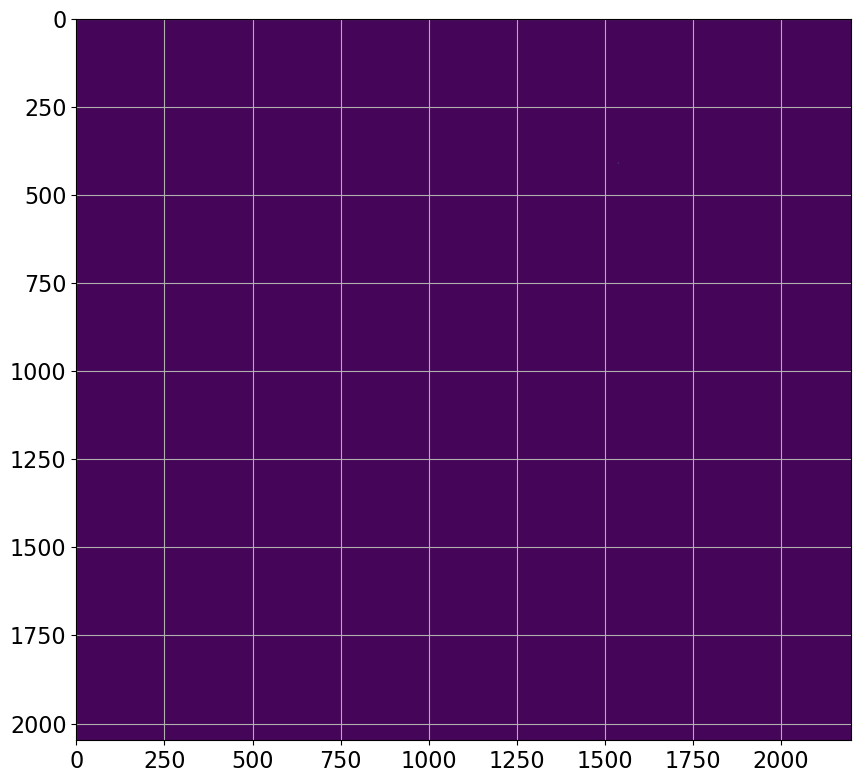

/home/kyle/anaconda3/envs/astro8060/lib/python3.9/site-packages/astropy/modeling/fitting.py:770: RuntimeWarning: invalid value encountered in true_divide
  lacoef /= scl[:, np.newaxis] if scl.ndim < rhs.ndim else scl
 [astropy.modeling.fitting]



ValueError: operands could not be broadcast together with shapes (2048,2200) (0,1) 

In [15]:
# set up the model that subtract_overscan will use this as an input
# you should adopt whatever you decided was a good idea from experimenting above
model = Polynomial1D(degree)

# this will loop over the bias frames
# it extracts the CCDData object and the filename for use in the loop
for ccd, file_name in imgs.ccds(ccd_kwargs={'unit': 'adu'},return_fname=True,imagetyp='bias'):
    # save the raw ccd data in case you want to plot a comparison later
    ccd_sav = ccd   
    
    print(file_name)
    plt.imshow(ccd.data)
    plt.show()
    # do the overscan subtraction
    # the overscan columns are collapsed with a mean (because median=False)
    # the mean overscan value is fit with the model you defined above
    ccd = ccdp.subtract_overscan(ccd, fits_section="[1:2048, 2122:2200]", median=False, model=model)  # subtract overscan, fits indexing
    ccd = ccdp.trim_image(ccd,fits_section=ccd.header['trimsec']) # trim images
    outfile = file_name.strip('.fits')+'ot.fits'
    ccd.write(reduced / outfile, overwrite=True) # save the result

In [73]:
model = Polynomial1D(degree)
ccd,name = imgs.ccds(ccd_kwargs={'unit': 'adu'},return_fname=True,imagetyp='bias')

generator